In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from utils import PkdbModel, caffeine_idx, measurement_type_data, filter_out, convert_unit, unstring
plt.style.use('seaborn-whitegrid')
import numpy as np

{'token': '4241a1580f26a51f470a716cbb84be132808f5a3'}


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def to_numeric(df_data):
    df_data[("weight","value")] = pd.to_numeric(df_data[("weight","value")])
    df_data[("weight","mean")] = pd.to_numeric(df_data[("weight","mean")])
    df_data["value_intervention"] = pd.to_numeric(df_data["value_intervention"])
    df_data["median"] = pd.to_numeric(df_data["median"])
    df_data["mean"] = pd.to_numeric(df_data["mean"])
    df_data["value"] = pd.to_numeric(df_data["value"])
    df_data["se"] = pd.to_numeric(df_data["se"])
    df_data["sd"] = pd.to_numeric(df_data["sd"])
    df_data["cv"] = pd.to_numeric(df_data["cv"])
    return df_data
     
def infer_from_interventions(data, unit_abs = "gram"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","value"),"value"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","value"),"value"])
    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","mean"),"mean"])
    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

def infer_from_outputs(data, unit_abs="liter / hour"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                                 unit_in=unit_abs,
                                 unit_out=unit_rel, 
                                 factor=1.0/data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'], 
                                 subset=[("weight","value"),"value"])

    data_abs_i = convert_unit(data,
                                 unit_in=unit_rel,
                                 unit_out=unit_abs, 
                                 factor=data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'],
                                 subset=[("weight","value"),"value"])
    

    data = pd.concat([data,data_rel,data_abs_i], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])


    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

In [4]:
all_complete = PkdbModel("all_complete", destination="2-merged")
all_complete.read()
all_complete.data.loc[(all_complete.data[("sex","choice")] == "M"),("oral contraceptives","choice")] = "N"
complete_caffeine = all_complete.data[caffeine_idx(all_complete.data)]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (15,19,23,24,25,28,29,30,31,44,72,88,90,114,115,117,119,121,123,124,126,127,128,129,132,133,134,136,140,144,145,147,148,149,151,152,172,174,175,176,177,179,180,182,184,186,188,194,195,196,203,204,208,211,212,220,225,229,230,235,239) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
caffeine_clearance = measurement_type_data(complete_caffeine,"clearance")
caffeine_clearance = filter_out(caffeine_clearance,"unit",["milliliter / meter ** 2 / minute"])

In [6]:
caffeine_clearance.groupby(["unit"]).apply(len)

unit
liter / hour               416
liter / hour / kilogram    408
dtype: int64

In [7]:
caffeine_clearance = to_numeric(caffeine_clearance)
caffeine_clearance = infer_from_interventions(caffeine_clearance,"gram")
caffeine_clearance = infer_from_outputs(caffeine_clearance,"liter / hour")


In [8]:
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour",unit_out="ml/min", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour / kilogram",unit_out="ml/min/kg", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [9]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.data = caffeine_clearance
caffeine_clr.save()

In [10]:
caffeine_clearance.groupby(["unit", "unit_intervention"]).apply(len)

unit       unit_intervention
ml/min     mg                   651
           mg/kg                480
ml/min/kg  mg                   632
           mg/kg                501
dtype: int64

In [11]:
caffeine_clearance.groupby(["calculated"]).apply(len)

calculated
False    1757
True      507
dtype: int64

## Timecourses

In [12]:
caffeine_timecourse = measurement_type_data(complete_caffeine,"concentration")
caffeine_timecourse = filter_out(caffeine_timecourse,"output_type",["outputs"])


In [13]:
caffeine_timecourse.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit         unit_intervention                                    
gram / liter gram                 105          105  105     105   
             gram / kilogram       23           23   23      23   
mole / liter gram                   5            5    5       5   
             gram / kilogram       12           12   12      12   

                                measurement_type  tissue  allowed_users  \
unit         unit_intervention                                            
gram / liter gram                            105     105            105   
             gram / kilogram                  23      23             23   
mole / liter gram                              5       5              5   
             gram / kilogram                  12      12             12   

                                substance  interventions  raw_pk  ...  \
unit         unit_intervention                                    ...   
gram / liter gram                     105            105     105  ...   
             gram / kilogram           23             23      23  ...   
mole / liter gram                       5              5       5  ...   
             gram / kilogram           12             12      12  ...   

                                (cyp2d6 variant, choice)  \
unit         unit_intervention                             
gram / liter gram                                      0   
             gram / kilogram                           0   
mole / liter gram                                      0   
             gram / kilogram                           0   

                                (cyp2d6 variant, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   
mole / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   
mole / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, mean)  (lean body mass, sd)  \
unit         unit_intervention                                                 
gram / liter gram                                    0                     0   
             gram / kilogram                         0                     0   
mole / liter gram                                    0                     0   
             gram / kilogram                         0                     0   

                                (lean body mass, unit)  (fat weight, count)  \
unit         unit_intervention                                                
gram / liter gram                                    0                    0   
             gram / kilogram                         0                    0   
mole / liter gram                                    0                    0   
             gram / kilogram                         0                   12   

                                (fat weight, mean)  (fat weight, se)  \
unit         unit_intervention                                         
gram / liter gram                                0                 0   
             gram / kilogram                     0                 0   
mole / liter gram                                0                 0   
             gram / kilogram                    12                12   

                                (fat weight, unit)  
unit         unit_intervention                      
gram / liter gram                                0  
             gram / kilogram                     0  
mole / liter gram                                0  
             g

In [14]:
caffeine_timecourse = filter_out(caffeine_timecourse,"unit",["mole / liter"])
caffeine_timecourse.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit         unit_intervention                                    
gram / liter gram                 105          105  105     105   
             gram / kilogram       23           23   23      23   

                                measurement_type  tissue  allowed_users  \
unit         unit_intervention                                            
gram / liter gram                            105     105            105   
             gram / kilogram                  23      23             23   

                                substance  interventions  raw_pk  ...  \
unit         unit_intervention                                    ...   
gram / liter gram                     105            105     105  ...   
             gram / kilogram           23             23      23  ...   

                                (cyp2d6 variant, choice)  \
unit         unit_intervention                             
gram / liter gram                                      0   
             gram / kilogram                           0   

                                (cyp2d6 variant, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, mean)  (lean body mass, sd)  \
unit         unit_intervention                                                 
gram / liter gram                                    0                     0   
             gram / kilogram                         0                     0   

                                (lean body mass, unit)  (fat weight, count)  \
unit         unit_intervention                                                
gram / liter gram                                    0                    0   
             gram / kilogram                         0                    0   

                                (fat weight, mean)  (fat weight, se)  \
unit         unit_intervention                                         
gram / liter gram                                0                 0   
             gram / kilogram                     0                 0   

                                (fat weight, unit)  
unit         unit_intervention                      
gram / liter gram                                0  
             gram / kilogram                     0  

[2 rows x 237 columns]

In [15]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.to_array()
caffeine_timecourse = caffeine_tc.data

In [16]:
caffeine_timecourse = infer_from_interventions(caffeine_timecourse,"gram")
caffeine_timecourse = infer_from_outputs(caffeine_timecourse,"gram / liter")

In [17]:
caffeine_timecourse.groupby(["unit","unit_intervention","time_unit"]).count()

study  output_type   pk  \
unit                    unit_intervention time_unit                            
gram / liter            gram              hr           121          121  121   
                        gram / kilogram   hr           118          118  118   
gram / liter / kilogram gram              hr           111          111  111   
                        gram / kilogram   hr           111          111  111   

                                                     access  measurement_type  \
unit                    unit_intervention time_unit                             
gram / liter            gram              hr            121               121   
                        gram / kilogram   hr            118               118   
gram / liter / kilogram gram              hr            111               111   
                        gram / kilogram   hr            111               111   

                                                     tissue  allowed_users  \
unit                    unit_intervention time_unit                          
gram / liter            gram              hr            121            121   
                        gram / kilogram   hr            118            118   
gram / liter / kilogram gram              hr            111            111   
                        gram / kilogram   hr            111            111   

                                                     substance  interventions  \
unit                    unit_intervention time_unit                             
gram / liter            gram              hr               121            121   
                        gram / kilogram   hr               118            118   
gram / liter / kilogram gram              hr               111            111   
                        gram / kilogram   hr               111            111   

                                                     raw_pk  ...  \
unit                    unit_intervention time_unit          ...   
gram / liter            gram              hr            121  ...   
                        gram / kilogram   hr            118  ...   
gram / liter / kilogram gram              hr            111  ...   
                        gram / kilogram   hr            111  ...   

                                                     (cyp2d6 variant, choice)  \
unit                    unit_intervention time_unit                             
gram / liter            gram              hr                                0   
                        gram / kilogram   hr                                0   
gram / liter / kilogram gram              hr                                0   
                        gram / kilogram   hr                                0   

                                                     (cyp2d6 variant, count)  \
unit                    unit_intervention time_unit                            
gram / liter            gram              hr                               0   
                        gram / kilogram   hr                               0   
gram / liter / kilogram gram              hr                               0   
                        gram / kilogram   hr                               0   

                                                     (lean body mass, count)  \
unit                    unit_intervention time_unit                            
gram / liter            gram              hr                               0   
                        gram / kilogram   hr                               0   
gram / liter / kilogram gram              hr                               0   
                        gram / kilogram   hr                               0   

                                                     (lean body mass, mean)  \
unit                    unit_intervention time_unit                           
gram / liter            gram              hr                              0   
                        gram / kil

In [18]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.save()

In [19]:
caffeine_thalf = measurement_type_data(complete_caffeine,"thalf")
caffeine_thalf = to_numeric(caffeine_thalf)
caffeine_thalf.groupby(["unit","unit_intervention"]).count()


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  access  measurement_type  \
unit unit_intervention                                                      
hour gram                 517          517  517     517               517   
     gram / kilogram      107          107  107     107               107   

                        tissue  allowed_users  substance  interventions  \
unit unit_intervention                                                    
hour gram                  517            517        517            517   
     gram / kilogram       107            107        107            107   

                        raw_pk  ...  (cyp2d6 variant, choice)  \
unit unit_intervention          ...                             
hour gram                  517  ...                         0   
     gram / kilogram       107  ...                         0   

                        (cyp2d6 variant, count)  (lean body mass, count)  \
unit unit_intervention                                                     
hour gram                                     0                        0   
     gram / kilogram                          0                        0   

                        (lean body mass, mean)  (lean body mass, sd)  \
unit unit_intervention                                                 
hour gram                                    0                     0   
     gram / kilogram                         0                     0   

                        (lean body mass, unit)  (fat weight, count)  \
unit unit_intervention                                                
hour gram                                    0                    0   
     gram / kilogram                         0                   20   

                        (fat weight, mean)  (fat weight, se)  \
unit unit_intervention                                         
hour gram                                0                 0   
     gram / kilogram                    20                20   

                        (fat weight, unit)  
unit unit_intervention                      
hour gram                                0  
     gram / kilogram                    20  

[2 rows x 237 columns]

In [20]:
caffeine_thalf = infer_from_interventions(caffeine_thalf,"gram")
caffeine_thalf = infer_from_outputs(caffeine_thalf,"hour")

In [21]:
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour",unit_out="hr", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour / kilogram",unit_out="hr/kg", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [22]:
caffeine_thalf.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  measurement_type  \
unit  unit_intervention                                                      
hr    mg                   603          603  603     603               603   
      mg/kg                492          492  492     492               492   
hr/kg mg                   471          471  471     471               471   
      mg/kg                471          471  471     471               471   

                         tissue  allowed_users  substance  interventions  \
unit  unit_intervention                                                    
hr    mg                    603            603        603            603   
      mg/kg                 492            492        492            492   
hr/kg mg                    471            471        471            471   
      mg/kg                 471            471        471            471   

                         raw_pk  ...  (cyp2d6 variant, choice)  \
unit  unit_intervention          ...                             
hr    mg                    603  ...                         0   
      mg/kg                 492  ...                         0   
hr/kg mg                    471  ...                         0   
      mg/kg                 471  ...                         0   

                         (cyp2d6 variant, count)  (lean body mass, count)  \
unit  unit_intervention                                                     
hr    mg                                       0                        0   
      mg/kg                                    0                        0   
hr/kg mg                                       0                        0   
      mg/kg                                    0                        0   

                         (lean body mass, mean)  (lean body mass, sd)  \
unit  unit_intervention                                                 
hr    mg                                      0                     0   
      mg/kg                                   0                     0   
hr/kg mg                                      0                     0   
      mg/kg                                   0                     0   

                         (lean body mass, unit)  (fat weight, count)  \
unit  unit_intervention                                                
hr    mg                                      0                   20   
      mg/kg                                   0                   20   
hr/kg mg                                      0                   20   
      mg/kg                                   0                   20   

                         (fat weight, mean)  (fat weight, se)  \
unit  unit_intervention                                         
hr    mg                                 20                20   
      mg/kg                              20                20   
hr/kg mg                                 20                20   
      mg/kg                              20                20   

                         (fat weight, unit)  
unit  unit_intervention                      
hr    mg                                 20  
      mg/kg                              20  
hr/kg mg                                 20  
      mg/kg                              20  

[4 rows x 237 columns]

In [23]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.data = caffeine_thalf
caffeine_thf.save()

In [24]:
caffeine_tmax = measurement_type_data(complete_caffeine,"tmax")
caffeine_tmax = to_numeric(caffeine_tmax)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [25]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  access  measurement_type  \
unit unit_intervention                                                      
hour gram                 227          227  227     227               227   
     gram / kilogram       60           60   60      60                60   

                        tissue  allowed_users  substance  interventions  \
unit unit_intervention                                                    
hour gram                  227            227        227            227   
     gram / kilogram        60             60         60             60   

                        raw_pk  ...  (cyp2d6 variant, choice)  \
unit unit_intervention          ...                             
hour gram                  227  ...                         0   
     gram / kilogram        60  ...                         0   

                        (cyp2d6 variant, count)  (lean body mass, count)  \
unit unit_intervention                                                     
hour gram                                     0                        0   
     gram / kilogram                          0                        0   

                        (lean body mass, mean)  (lean body mass, sd)  \
unit unit_intervention                                                 
hour gram                                    0                     0   
     gram / kilogram                         0                     0   

                        (lean body mass, unit)  (fat weight, count)  \
unit unit_intervention                                                
hour gram                                    0                    0   
     gram / kilogram                         0                   20   

                        (fat weight, mean)  (fat weight, se)  \
unit unit_intervention                                         
hour gram                                0                 0   
     gram / kilogram                    20                20   

                        (fat weight, unit)  
unit unit_intervention                      
hour gram                                0  
     gram / kilogram                    20  

[2 rows x 237 columns]

In [26]:
caffeine_tmax = infer_from_interventions(caffeine_tmax)
caffeine_tmax = infer_from_outputs(caffeine_tmax, "hour")

In [27]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit            unit_intervention                                    
hour            gram                 266          266  266     266   
                gram / kilogram      203          203  203     203   
hour / kilogram gram                 182          182  182     182   
                gram / kilogram      182          182  182     182   

                                   measurement_type  tissue  allowed_users  \
unit            unit_intervention                                            
hour            gram                            266     266            266   
                gram / kilogram                 203     203            203   
hour / kilogram gram                            182     182            182   
                gram / kilogram                 182     182            182   

                                   substance  interventions  raw_pk  ...  \
unit            unit_intervention                                    ...   
hour            gram                     266            266     266  ...   
                gram / kilogram          203            203     203  ...   
hour / kilogram gram                     182            182     182  ...   
                gram / kilogram          182            182     182  ...   

                                   (cyp2d6 variant, choice)  \
unit            unit_intervention                             
hour            gram                                      0   
                gram / kilogram                           0   
hour / kilogram gram                                      0   
                gram / kilogram                           0   

                                   (cyp2d6 variant, count)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (lean body mass, count)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (lean body mass, mean)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (lean body mass, sd)  \
unit            unit_intervention                         
hour            gram                                  0   
                gram / kilogram                       0   
hour / kilogram gram                                  0   
                gram / kilogram                       0   

                                   (lean body mass, unit)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (fat weight, count)  (fat weight, mean)  \
unit            unit_intervention                                            
hour            gram                                20                  20   
                gram / kilogram                     20                  20   
hour / kilogram gram                                20                  20   
                gram / kilogram                     20                  20   

     

In [28]:
caffeine_tmx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_tmx.data = caffeine_tmax
caffeine_tmx.save()

In [29]:
caffeine_vd = measurement_type_data(complete_caffeine,"vd")
caffeine_vd = to_numeric(caffeine_vd)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [30]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit             unit_intervention                                    
liter            gram                 247          247  247     247   
                 gram / kilogram       11           11   11      11   
liter / kilogram gram                 160          160  160     160   
                 gram / kilogram       82           82   82      82   

                                    measurement_type  tissue  allowed_users  \
unit             unit_intervention                                            
liter            gram                            247     247            247   
                 gram / kilogram                  11      11             11   
liter / kilogram gram                            160     160            160   
                 gram / kilogram                  82      82             82   

                                    substance  interventions  raw_pk  ...  \
unit             unit_intervention                                    ...   
liter            gram                     247            247     247  ...   
                 gram / kilogram           11             11      11  ...   
liter / kilogram gram                     160            160     160  ...   
                 gram / kilogram           82             82      82  ...   

                                    (cyp2d6 variant, choice)  \
unit             unit_intervention                             
liter            gram                                      0   
                 gram / kilogram                           0   
liter / kilogram gram                                      0   
                 gram / kilogram                           0   

                                    (cyp2d6 variant, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, mean)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (lean body mass, sd)  \
unit             unit_intervention                         
liter            gram                                  0   
                 gram / kilogram                       0   
liter / kilogram gram                                  0   
                 gram / kilogram                       0   

                                    (lean body mass, unit)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                 0                   0   
                 gram / kilogram                      0                   0   
liter / kilogram gram                                 0                   0   
                 gram / ki

In [31]:
caffeine_vd["weight"] = caffeine_vd[("weight","mean")]
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention","weight"]]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention,weight


In [32]:
71*1.050000

74.55

In [33]:
49.33*1.05

51.7965

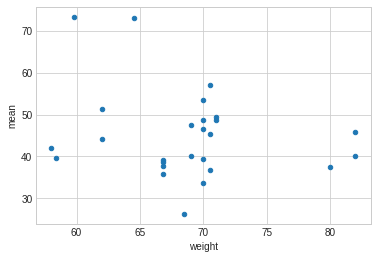

In [34]:
caffeine_vd[caffeine_vd["unit"]=="liter"][["weight","mean","value"]].plot(x="weight",y="mean",kind="scatter")

In [35]:
caffeine_vd =  infer_from_interventions(caffeine_vd, "gram")
caffeine_vd =  infer_from_outputs(caffeine_vd, "liter")

In [36]:
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention"]]

,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention


In [37]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit             unit_intervention                                    
liter            gram                 410          410  410     410   
                 gram / kilogram      364          364  364     364   
liter / kilogram gram                 431          431  431     431   
                 gram / kilogram      387          387  387     387   

                                    measurement_type  tissue  allowed_users  \
unit             unit_intervention                                            
liter            gram                            410     410            410   
                 gram / kilogram                 364     364            364   
liter / kilogram gram                            431     431            431   
                 gram / kilogram                 387     387            387   

                                    substance  interventions  raw_pk  ...  \
unit             unit_intervention                                    ...   
liter            gram                     410            410     410  ...   
                 gram / kilogram          364            364     364  ...   
liter / kilogram gram                     431            431     431  ...   
                 gram / kilogram          387            387     387  ...   

                                    (cyp2d6 variant, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, mean)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (lean body mass, sd)  \
unit             unit_intervention                         
liter            gram                                  0   
                 gram / kilogram                       0   
liter / kilogram gram                                  0   
                 gram / kilogram                       0   

                                    (lean body mass, unit)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                20                  20   
                 gram / kilogram                     20                  20   
liter / kilogram gram                                20                  20   
                 gram / kilogram                     20                  20   

                                    (fat weight, se)  (fat weight, unit)  \
unit             unit_intervention                                         
liter            gram                             20                  20   
                 gram / kilogram                  20                  20   
liter / kilogram gram      

In [38]:
caffeine_vd_model = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_vd_model.data = caffeine_vd
caffeine_vd_model.save()

In [39]:
caffeine_auc_inf = measurement_type_data(complete_caffeine,"auc_inf")
caffeine_auc_inf = to_numeric(caffeine_auc_inf)
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  access  \
unit                unit_intervention                                    
gram * hour / liter gram                 320          320  320     320   
                    gram / kilogram       47           47   47      47   

                                       measurement_type  tissue  \
unit                unit_intervention                             
gram * hour / liter gram                            320     320   
                    gram / kilogram                  47      47   

                                       allowed_users  substance  \
unit                unit_intervention                             
gram * hour / liter gram                         320        320   
                    gram / kilogram               47         47   

                                       interventions  raw_pk  ...  \
unit                unit_intervention                         ...   
gram * hour / liter gram                         320     320  ...   
                    gram / kilogram               47      47  ...   

                                       (cyp2d6 variant, choice)  \
unit                unit_intervention                             
gram * hour / liter gram                                      0   
                    gram / kilogram                           0   

                                       (cyp2d6 variant, count)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (lean body mass, count)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (lean body mass, mean)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (lean body mass, sd)  \
unit                unit_intervention                         
gram * hour / liter gram                                  0   
                    gram / kilogram                       0   

                                       (lean body mass, unit)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (fat weight, count)  \
unit                unit_intervention                        
gram * hour / liter gram                                 0   
                    gram / kilogram                     18   

                                       (fat weight, mean)  (fat weight, se)  \
unit                unit_intervention                                         
gram * hour / liter gram                                0                 0   
                    gram / kilogram                    18                18   

                                       (fat weight, unit)  
unit                unit_intervention                      
gram * hour / liter gram                                0  
                    gram / kilogram                    18  

[2 rows x 237 columns]

In [40]:
caffeine_auc_inf =  infer_from_interventions(caffeine_auc_inf, "gram ")
caffeine_auc_inf =  infer_from_outputs(caffeine_auc_inf, "gram * hour / liter")

In [41]:
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  \
unit                           unit_intervention                            
gram * hour / liter            gram                 320          320  320   
                               gram / kilogram       47           47   47   
gram * hour / liter / kilogram gram                 274          274  274   
                               gram / kilogram       40           40   40   

                                                  access  measurement_type  \
unit                           unit_intervention                             
gram * hour / liter            gram                  320               320   
                               gram / kilogram        47                47   
gram * hour / liter / kilogram gram                  274               274   
                               gram / kilogram        40                40   

                                                  tissue  allowed_users  \
unit                           unit_intervention                          
gram * hour / liter            gram                  320            320   
                               gram / kilogram        47             47   
gram * hour / liter / kilogram gram                  274            274   
                               gram / kilogram        40             40   

                                                  substance  interventions  \
unit                           unit_intervention                             
gram * hour / liter            gram                     320            320   
                               gram / kilogram           47             47   
gram * hour / liter / kilogram gram                     274            274   
                               gram / kilogram           40             40   

                                                  raw_pk  ...  \
unit                           unit_intervention          ...   
gram * hour / liter            gram                  320  ...   
                               gram / kilogram        47  ...   
gram * hour / liter / kilogram gram                  274  ...   
                               gram / kilogram        40  ...   

                                                  (cyp2d6 variant, choice)  \
unit                           unit_intervention                             
gram * hour / liter            gram                                      0   
                               gram / kilogram                           0   
gram * hour / liter / kilogram gram                                      0   
                               gram / kilogram                           0   

                                                  (cyp2d6 variant, count)  \
unit                           unit_intervention                            
gram * hour / liter            gram                                     0   
                               gram / kilogram                          0   
gram * hour / liter / kilogram gram                                     0   
                               gram / kilogram                          0   

                                                  (lean body mass, count)  \
unit                           unit_intervention                            
gram * hour / liter            gram                                     0   
                               gram / kilogram                          0   
gram * hour / liter / kilogram gram                                     0   
                               gram / kilogram                          0   

                                                  (lean body mass, mean)  \
unit                           unit_intervention                           
gram * hour / liter            gram                                    0   
                               gram / kilogram                         0   
gram * hour / liter / kilogram gram                                    0   
                               g

In [42]:
caffeine_auc_inf_model = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_auc_inf_model.data = caffeine_auc_inf
caffeine_auc_inf_model.save()

In [43]:
complete_caffeine.groupby("measurement_type").count()

,study,output_type,pk,access,tissue,allowed_users,substance,interventions,raw_pk,unit,...,"(cyp2d6 variant, choice)","(cyp2d6 variant, count)","(lean body mass, count)","(lean body mass, mean)","(lean body mass, sd)","(lean body mass, unit)","(fat weight, count)","(fat weight, mean)","(fat weight, se)","(fat weight, unit)"
measurement_type,,,,,,,,,,,,,,,,,,,,,
auc_end,172,172,172,172,172,172,172,172,172,172,...,0,0,0,0,0,0,10,10,10,10
auc_inf,367,367,367,367,367,367,367,367,367,367,...,0,0,0,0,0,0,18,18,18,18
clearance,826,826,826,826,826,826,826,826,826,826,...,0,0,0,0,0,0,20,20,20,20
clearance_intrinsic,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
clearance_intrinsic_unbound,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
clearance_renal,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
clearance_unbound,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,0,0
cmax,285,285,285,285,285,285,285,285,285,285,...,0,0,0,0,0,0,18,18,18,18
concentration,197,197,197,197,197,197,197,197,197,197,...,0,0,10,10,10,10,12,12,12,12


In [44]:
caffeine_kel = measurement_type_data(complete_caffeine,"kel")
caffeine_kel = to_numeric(caffeine_kel)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [45]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  access  \
unit       unit_intervention                                    
1 / minute gram                 214          214  214     214   
           gram / kilogram       73           73   73      73   

                              measurement_type  tissue  allowed_users  \
unit       unit_intervention                                            
1 / minute gram                            214     214            214   
           gram / kilogram                  73      73             73   

                              substance  interventions  raw_pk  ...  \
unit       unit_intervention                                    ...   
1 / minute gram                     214            214     214  ...   
           gram / kilogram           73             73      73  ...   

                              (cyp2d6 variant, choice)  \
unit       unit_intervention                             
1 / minute gram                                      0   
           gram / kilogram                           0   

                              (cyp2d6 variant, count)  \
unit       unit_intervention                            
1 / minute gram                                     0   
           gram / kilogram                          0   

                              (lean body mass, count)  (lean body mass, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                     0                       0   
           gram / kilogram                          0                       0   

                              (lean body mass, sd)  (lean body mass, unit)  \
unit       unit_intervention                                                 
1 / minute gram                                  0                       0   
           gram / kilogram                       0                       0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                 0                   0   
           gram / kilogram                     20                  20   

                              (fat weight, se)  (fat weight, unit)  
unit       unit_intervention                                        
1 / minute gram                              0                   0  
           gram / kilogram                  20                  20  

[2 rows x 237 columns]

In [46]:
caffeine_kel =  infer_from_interventions(caffeine_kel, "gram")
caffeine_kel =  infer_from_outputs(caffeine_kel, "1/minute")

In [47]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  access  \
unit       unit_intervention                                    
1 / minute gram                 280          280  280     280   
           gram / kilogram      278          278  278     278   

                              measurement_type  tissue  allowed_users  \
unit       unit_intervention                                            
1 / minute gram                            280     280            280   
           gram / kilogram                 278     278            278   

                              substance  interventions  raw_pk  ...  \
unit       unit_intervention                                    ...   
1 / minute gram                     280            280     280  ...   
           gram / kilogram          278            278     278  ...   

                              (cyp2d6 variant, choice)  \
unit       unit_intervention                             
1 / minute gram                                      0   
           gram / kilogram                           0   

                              (cyp2d6 variant, count)  \
unit       unit_intervention                            
1 / minute gram                                     0   
           gram / kilogram                          0   

                              (lean body mass, count)  (lean body mass, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                     0                       0   
           gram / kilogram                          0                       0   

                              (lean body mass, sd)  (lean body mass, unit)  \
unit       unit_intervention                                                 
1 / minute gram                                  0                       0   
           gram / kilogram                       0                       0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                20                  20   
           gram / kilogram                     20                  20   

                              (fat weight, se)  (fat weight, unit)  
unit       unit_intervention                                        
1 / minute gram                             20                  20  
           gram / kilogram                  20                  20  

[2 rows x 237 columns]

In [48]:
caffeine_kel_model = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_kel_model.data = caffeine_kel
caffeine_kel_model.save()

In [49]:
caffeine_vd.columns.to_list()

['study',
 'output_type',
 'pk',
 'access',
 'measurement_type',
 'tissue',
 'allowed_users',
 'substance',
 'interventions',
 'raw_pk',
 'unit',
 'calculated',
 'individual_name',
 'individual_pk',
 'value',
 'group_pk',
 'group_name',
 'group_count',
 'mean',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'choice',
 'raw_pk_intervention',
 'allowed_users_intervention',
 'measurement_type_intervention',
 'access_intervention',
 'route',
 'substance_intervention',
 'unit_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice_intervention',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'sd_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age',

In [50]:
caffeine_vd.rename(columns={("weight","mean"):"weight"}, inplace=True)


In [51]:
#caffeine_vd[caffeine_vd["group_pk"] == 905][["study","group_count","group_pk","mean","unit","unit_intervention",'weight']]